# Pull Down QCFractal Dataset
Get the data from the QCFractal server running on Theta

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from moldesign.simulate import compute_reference_energy, subtract_reference_energies
from qcelemental.models.procedures import QCInputSpecification
from qcelemental.models import Molecule
from qcportal.client import FractalClient
from qcportal import collections as qcpc
import numpy as np
import json
import os

/home/wardlt/miniconda3/envs/colmena_full/lib/python3.7/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


Reference data

In [2]:
multiplicity = {'H': 2, 'He': 1, 'Li': 2, 'C': 3, 'N': 4, 'O': 3, 'F': 2}

## Connect the Server
Our QCFractal server sits on `thetalogin6`, which I connect to via a SSH tunnel on port 7834

In [3]:
client = FractalClient('localhost:7874', verify=False, username='user',
                      password=os.environ.get('QCAUSR'))

In [4]:
client.server_information()

{'client_lower_version_limit': '0.12.1',
 'client_upper_version_limit': '0.13.99',
 'counts': {'collection': 7,
  'molecule': 218390,
  'result': 237121,
  'kvstore': 115690},
 'heartbeat_frequency': 1800,
 'name': 'QCFractal Server',
 'query_limit': 1000,
 'version': 'v0.12.1+232.g64428bae'}

## Access the Collection
A collection is route for managing ensembles of calculations in QCFractal. I have made one for the purpose of creating the initial seed dataset

In [5]:
coll = client.get_collection('OptimizationDataset', name='Colmena Initial Dataset')

Display general status

In [6]:
specs = coll.list_specifications(False)
for spec in specs: coll.query(spec)
coll.status()

,small_basis,default
COMPLETE,815,NaN
ERROR,148,NaN
INCOMPLETE,537,NaN


Get only the "COMPLETE" calcualtions for the small basis

In [7]:
df = coll.df[coll.df.small_basis.apply(lambda x: x.status.value == 'COMPLETE')][['small_basis']]

Get the molecular structure, total energy, and runtime

In [8]:
r = df.small_basis.iloc[0]

In [9]:
df['mol'] = df['small_basis'].apply(lambda r: r.get_final_molecule())

In [10]:
df['xyz'] = df['mol'].apply(lambda x: x.to_string('xyz'))

In [11]:
df['u_e'] = df['small_basis'].apply(lambda r: r.get_final_energy())

In [12]:
df['n_electrons'] = df['mol'].apply(Molecule.nelectrons)

In [13]:
df['runtime'] = df['small_basis'].apply(lambda r: r.provenance.wall_time)

In [14]:
df['runtime'].describe()

count      815.000000
mean      1420.613756
std       1228.146368
min        333.239939
25%        802.468047
50%       1026.244500
75%       1481.857644
max      11171.421887
Name: runtime, dtype: float64

Text(0, 0.5, 'Frequency')

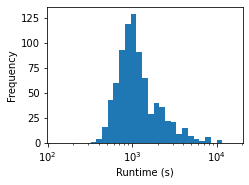

In [15]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.hist(df['runtime'], bins=np.logspace(2.1, 4.2, 32))
ax.set_xscale('log')

ax.set_xlabel('Runtime (s)')
ax.set_ylabel('Frequency')

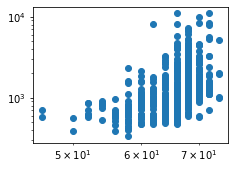

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.scatter(df['n_electrons'], df['runtime'])
ax.set_yscale('log')
ax.set_xscale('log')

## Compute the Atomization Energy
We are going to compute the reference energies first, because doing so is quick

Get the correct specification

In [17]:
spec = r.qc_spec.dict()

In [18]:
kwargs = client.query_keywords(r.qc_spec.keywords)[0]
spec['keywords'] = kwargs.values

In [19]:
spec = QCInputSpecification(model={'method': spec['method'], 'basis': spec['basis']}, keywords=spec['keywords'])

In [20]:
ref_energies = dict((e, compute_reference_energy(e, spec, m, 'nwchem')) for e, m in multiplicity.items())

building CURRENT CORRELATION ENERGY ........................SUCCESS
building CURRENT CORRELATION ENERGY ........................SUCCESS
building CURRENT CORRELATION ENERGY ........................SUCCESS
building CURRENT CORRELATION ENERGY ........................SUCCESS
building CURRENT CORRELATION ENERGY ........................SUCCESS
building CURRENT CORRELATION ENERGY ........................SUCCESS
building CURRENT CORRELATION ENERGY ........................SUCCESS


In [21]:
with open('ref_energies.json', 'w') as fp:
    json.dump(ref_energies, fp)

Compute it 

In [22]:
df['u_e_atom'] = df.apply(lambda r: subtract_reference_energies(r['u_e'], r['mol'], ref_energies), axis=1)

In [23]:
df

,small_basis,mol,xyz,u_e,n_electrons,runtime,u_e_atom
CC1=C(CCC1)C1CN1,"OptimizationRecord(id='209688', status='COMPLE...","Molecule(name='C8H13N', formula='C8H13N', hash...",22\n0 1 C8H13N\nC -0.191085...,-365.352168,68,2037.618881,-3.450086
COC12CCC1C1CC21,"OptimizationRecord(id='209689', status='COMPLE...","Molecule(name='C8H12O', formula='C8H12O', hash...",21\n0 1 C8H12O\nC 0.013119...,-385.058496,68,4464.605268,-3.288894
OC1CC2CC12,"OptimizationRecord(id='209690', status='COMPLE...","Molecule(name='C5H8O', formula='C5H8O', hash='...",14\n0 1 C5H8O\nO -0.1753102...,-268.998752,46,706.820857,-2.146485
CC1C2CCC1C1CC21,"OptimizationRecord(id='209691', status='COMPLE...","Molecule(name='C9H14', formula='C9H14', hash='...",23\n0 1 C9H14\nC -0.0576958...,-349.441955,68,627.940747,-3.695327
COC12CC(C1C)C2=O,"OptimizationRecord(id='209752', status='COMPLE...","Molecule(name='C7H10O2', formula='C7H10O2', ha...",19\n0 1 C7H10O2\nC 0.49642...,-420.793177,68,3382.608842,-3.000602
...,...,...,...,...,...,...,...
CC1OC(C)(C=O)C=C1,"OptimizationRecord(id='210837', status='COMPLE...","Molecule(name='C7H10O2', formula='C7H10O2', ha...",19\n0 1 C7H10O2\nC 0.04497...,-420.852776,68,1026.244500,-3.060201
CC12CC1NC=C2C=O,"OptimizationRecord(id='210838', status='COMPLE...","Molecule(name='C7H9NO', formula='C7H9NO', hash...",18\n0 1 C7H9NO\nC -0.060320...,-399.865148,66,955.806171,-2.934715
CCC#CC1=COC=N1,"OptimizationRecord(id='210841', status='COMPLE...","Molecule(name='C7H7NO', formula='C7H7NO', hash...",16\n0 1 C7H7NO\nC -0.043827...,-398.640802,64,696.897092,-2.704991
NC(=O)C1COC1C#C,"OptimizationRecord(id='210842', status='COMPLE...","Molecule(name='C6H7NO2', formula='C6H7NO2', ha...",16\n0 1 C6H7NO2\nN 0.44672...,-435.536036,66,771.955753,-2.582628


In [24]:
df.drop(columns={'mol', 'small_basis'}).to_csv('initial_nwchem.csv', index_label='smiles')